In [1]:
!nvidia-smi  --query-gpu=name,memory.total,memory.used --format=csv,noheader

NVIDIA GeForce GTX 1060 6GB, 6144 MiB, 557 MiB


Coded by E. Porter

In [34]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve, classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

Label_encoder = LabelEncoder()

In [35]:
# Load the train data_trainset
data_train = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)

#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_train['gender'] = data_train['gender'].map(gender_conversion)

data_train['name'] = data_train['first'] + " " + data_train['last']
data_train['address'] = data_train['street'] + ", " + data_train['city'] + ", " + data_train['state']

#Convert first name
data_train['first#'] = Label_encoder.fit_transform(data_train['first'])

#Convert last  name
data_train['last#'] = Label_encoder.fit_transform(data_train['last'])

#Convert first name + last name
data_train['name#'] = Label_encoder.fit_transform(data_train['name'])

#data_train['age'] = 2024 - pd.to_numeric(data_train['dob'].str[:4]) 

#Convert Job
data_train['job#'] = Label_encoder.fit_transform(data_train['job'])

data_train['merchant#'] = Label_encoder.fit_transform(data_train['merchant'])

data_train['category#'] = Label_encoder.fit_transform(data_train['category'])


data_train['street#'] = Label_encoder.fit_transform(data_train['street'])
data_train['city#'] = Label_encoder.fit_transform(data_train['city'])
data_train['state#'] = Label_encoder.fit_transform(data_train['state'])

data_train['address#'] = Label_encoder.fit_transform(data_train['address'])

data_train['trans_num'] = Label_encoder.fit_transform(data_train['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_train['age'] = data_train['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_train['distance_km'] = haversine(data_train['lat'], data_train['long'], data_train['merch_lat'], data_train['merch_long'])


data_train = data_train.drop(columns=['first', 'last', 'name', 'address','street', 'street', 'city', 'state', 'category', 'job', 'trans_date_trans_time', 'Unnamed: 0', 'dob','merchant'])
#data_train = data_train.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])



data_train.head()

,cc_num,amt,gender,zip,lat,long,city_pop,trans_num,unix_time,merch_lat,merch_long,is_fraud,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,2.86,1,29209,33.9659,-80.9355,333497,98699,1371816865,33.986391,-81.200714,0,151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,29.84,0,84002,40.3207,-110.4360,302,108785,1371816873,39.450498,-109.960431,0,163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,41.28,0,11710,40.6729,-73.5365,34496,433979,1371816893,40.495810,-74.196111,0,24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,60.05,1,32780,28.5697,-80.8191,54767,71993,1371816915,28.812398,-80.883061,0,42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,3.19,1,49632,44.2529,-85.0170,1126,190585,1371816917,44.959148,-85.884734,0,247,261,678,196,292,13,548,247,21,548,69,104.335106


In [36]:
# Load the test dataset
data_test = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)


#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_test['gender'] = data_test['gender'].map(gender_conversion)

data_test['name'] = data_test['first'] + " " + data_test['last']
data_test['address'] = data_test['street'] + ", " + data_test['city'] + ", " + data_test['state']

#Convert first name
data_test['first#'] = Label_encoder.fit_transform(data_test['first'])

#Convert last  name
data_test['last#'] = Label_encoder.fit_transform(data_test['last'])

#Convert first name + last name
data_test['name#'] = Label_encoder.fit_transform(data_test['name'])

#data_test['age'] = 2024 - pd.to_numeric(data_test['dob'].str[:4]) 

#Convert Job
data_test['job#'] = Label_encoder.fit_transform(data_test['job'])

data_test['merchant#'] = Label_encoder.fit_transform(data_test['merchant'])

data_test['category#'] = Label_encoder.fit_transform(data_test['category'])


data_test['street#'] = Label_encoder.fit_transform(data_test['street'])
data_test['city#'] = Label_encoder.fit_transform(data_test['city'])
data_test['state#'] = Label_encoder.fit_transform(data_test['state'])

data_test['address#'] = Label_encoder.fit_transform(data_test['address'])

data_test['trans_num'] = Label_encoder.fit_transform(data_test['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_test['age'] = data_test['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_test['distance_km'] = haversine(data_test['lat'], data_test['long'], data_test['merch_lat'], data_test['merch_long'])


data_test = data_test.drop(columns=['first', 'last', 'name', 'address','street', 'street', 'city', 'state', 'category', 'job', 'trans_date_trans_time', 'Unnamed: 0', 'dob','merchant'])
#data_test = data_test.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])



data_test.head()

,cc_num,amt,gender,zip,lat,long,city_pop,trans_num,unix_time,merch_lat,merch_long,is_fraud,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,2.86,1,29209,33.9659,-80.9355,333497,98699,1371816865,33.986391,-81.200714,0,151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,29.84,0,84002,40.3207,-110.4360,302,108785,1371816873,39.450498,-109.960431,0,163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,41.28,0,11710,40.6729,-73.5365,34496,433979,1371816893,40.495810,-74.196111,0,24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,60.05,1,32780,28.5697,-80.8191,54767,71993,1371816915,28.812398,-80.883061,0,42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,3.19,1,49632,44.2529,-85.0170,1126,190585,1371816917,44.959148,-85.884734,0,247,261,678,196,292,13,548,247,21,548,69,104.335106


C:\Users\ejporter\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\ejporter\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\ejporter\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder"

Training Evaluation:
Recall: 0.7053613053613054
F1-Score: 0.026037498816868444
AUC-ROC: 0.8228747467095006

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    553574
           1       0.01      0.71      0.03      2145

    accuracy                           0.80    555719
   macro avg       0.51      0.75      0.46    555719
weighted avg       0.99      0.80      0.88    555719



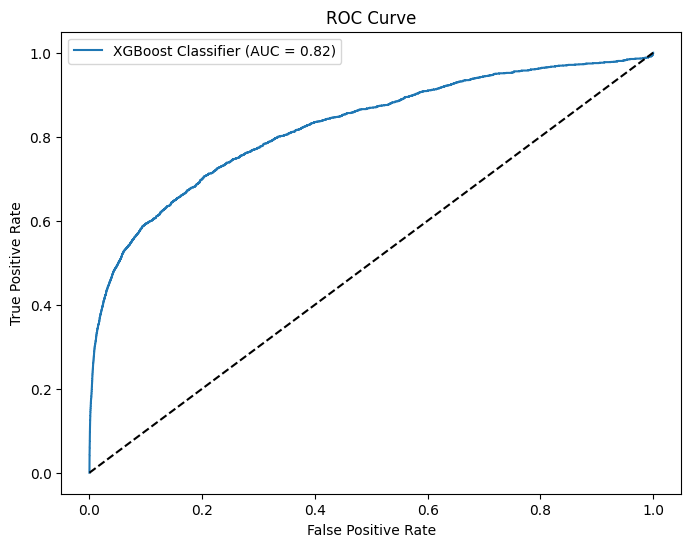

C:\Users\ejporter\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:22:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Test Evaluation Metrics:
Recall: 1.0
F1-Score: 0.0661536800875881
AUC-ROC: 0.9999803068213073
XGBoost EVEL_METRIC =['auc', 'logloss', 'error'] 
Accuracy: 0.8910258601919315
AUC Score: 0.9999803068213073

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    553574
           1       0.03      1.00      0.07      2145

    accuracy                           0.89    555719
   macro avg       0.52      0.95      0.50    555719
weighted avg       1.00      0.89      0.94    555719



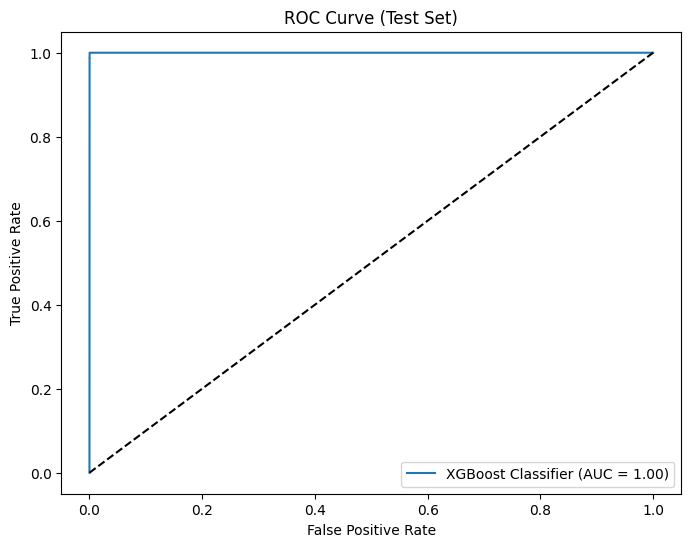

In [37]:


    
# Define features and target
X_train, y_train = data_train.drop(columns=['is_fraud']), data_train['is_fraud']
X_test, y_test = data_test.drop(columns=['is_fraud']), data_test['is_fraud']


# Handle missing values and scaling
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Model setup
pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_model = XGBClassifier(scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric=['auc', 'logloss', 'error'], random_state=20201107)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# 2-Fold Cross Validation
cv = StratifiedKFold(n_splits=10)
y_proba_cv = cross_val_predict(pipeline, X_train, y_train, cv=cv, method='predict_proba')

# Threshold Tuning
fpr, tpr, thresholds = roc_curve(y_train, y_proba_cv[:, 1])
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

# Make predictions using the tuned threshold
y_pred_cv = (y_proba_cv[:, 1] >= optimal_threshold).astype(int)

# Evaluation

print("Training Evaluation:")
print("Recall:", recall_score(y_train, y_pred_cv))
print("F1-Score:", f1_score(y_train, y_pred_cv))
print("AUC-ROC:", roc_auc_score(y_train, y_proba_cv[:, 1]))
print("\nClassification Report:\n", classification_report(y_train, y_pred_cv))

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost Classifier (AUC = {roc_auc_score(y_train, y_proba_cv[:, 1]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



# Train the model
xgb_model.fit(X_train, y_train)

# Continue with predictions and evaluations
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

print("\nTest Evaluation Metrics:")
print("Recall:", recall_score(y_test, y_test_pred))
print("F1-Score:", f1_score(y_test, y_test_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_test_proba))

# Evaluation
print("XGBoost EVEL_METRIC =['auc', 'logloss', 'error'] ")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("AUC Score:", roc_auc_score(y_test, y_test_proba))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


# Plotting ROC Curve for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f'XGBoost Classifier (AUC = {roc_auc_score(y_test, y_test_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.show()


C:\Users\ejporter\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\ejporter\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\ejporter\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\ejporter\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the defa

Training Evaluation:
Recall: 0.6470862470862471
F1-Score: 0.024474106465889656
AUC-ROC: 0.7510143995589482

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    553574
           1       0.01      0.65      0.02      2145

    accuracy                           0.80    555719
   macro avg       0.51      0.72      0.46    555719
weighted avg       0.99      0.80      0.89    555719



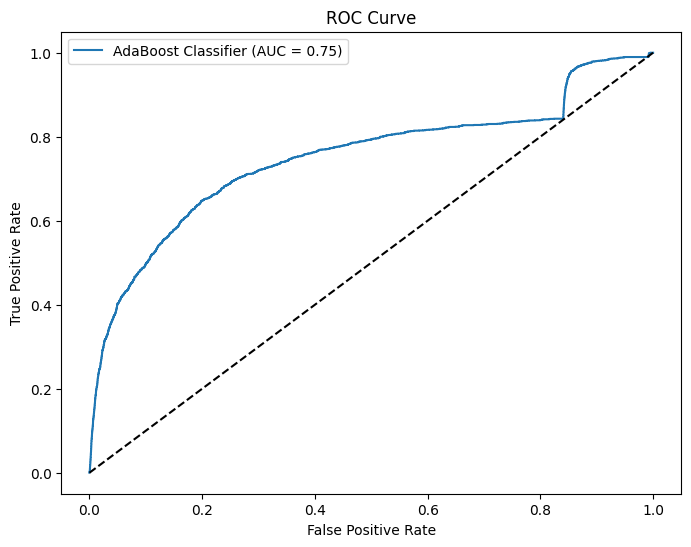

C:\Users\ejporter\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Test Evaluation Metrics:
Recall: 0.9431235431235431
F1-Score: 0.10537007135788322
AUC-ROC: 0.9871573184577408
Random Forest 100 Trees (All Features)
Accuracy: 0.938184586094771
AUC Score: 0.9871573184577408

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    553574
           1       0.06      0.94      0.11      2145

    accuracy                           0.94    555719
   macro avg       0.53      0.94      0.54    555719
weighted avg       1.00      0.94      0.96    555719



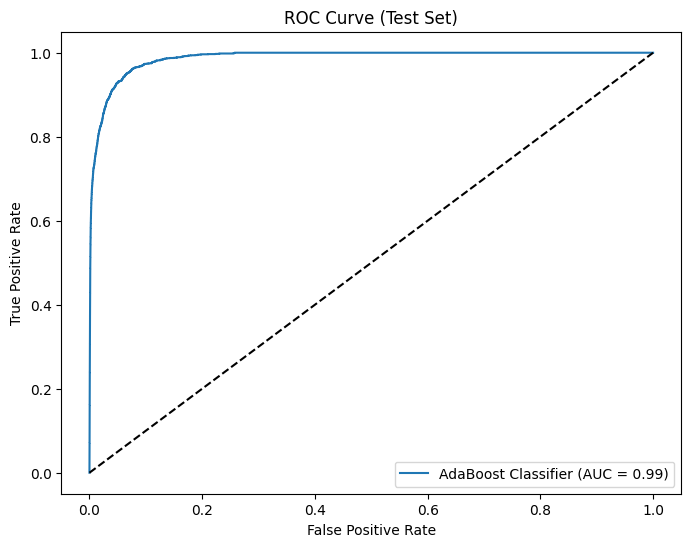

In [38]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier


# Model setup - Use AdaBoost with DecisionTreeClassifier as the base estimator
estimator = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(estimator=estimator, n_estimators=200, random_state=20201107)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', adaboost_model)
])

# 2-Fold Cross Validation
cv = StratifiedKFold(n_splits=10)
y_proba_cv = cross_val_predict(pipeline, X_train, y_train, cv=cv, method='predict_proba')

# Threshold Tuning
fpr, tpr, thresholds = roc_curve(y_train, y_proba_cv[:, 1])
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

# Make predictions using the tuned threshold
y_pred_cv = (y_proba_cv[:, 1] >= optimal_threshold).astype(int)

# Evaluation
print("Training Evaluation:")
print("Recall:", recall_score(y_train, y_pred_cv))
print("F1-Score:", f1_score(y_train, y_pred_cv))
print("AUC-ROC:", roc_auc_score(y_train, y_proba_cv[:, 1]))
print("\nClassification Report:\n", classification_report(y_train, y_pred_cv))

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AdaBoost Classifier (AUC = {roc_auc_score(y_train, y_proba_cv[:, 1]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Train the model
adaboost_model.fit(X_train, y_train)

# Continue with predictions and evaluations
y_test_proba = adaboost_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

print("\nTest Evaluation Metrics:")
print("Recall:", recall_score(y_test, y_test_pred))
print("F1-Score:", f1_score(y_test, y_test_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_test_proba))

# Evaluation
print("Random Forest 100 Trees (All Features)")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("AUC Score:", roc_auc_score(y_test, y_test_proba))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Plotting ROC Curve for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, label=f'AdaBoost Classifier (AUC = {roc_auc_score(y_test, y_test_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.show()